In [1]:
%%capture
# Install Unsloth and dependencies
# What's happening: Installing libraries for reinforcement learning-based training
# Key libraries for GRPO:
#   - unsloth: Optimizes RL training (faster policy updates, efficient sampling)
#   - trl: Contains trainers for RL methods (PPO, GRPO, etc.)
#   - peft: LoRA implementation for parameter-efficient RL fine-tuning
!pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"
!pip install --no-deps xformers trl peft accelerate bitsandbytes

In [2]:
import torch
print(f"GPU Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")
    print(f"BF16 Support: {torch.cuda.is_bf16_supported()}")

GPU Available: True
GPU Name: Tesla T4
GPU Memory: 14.74 GB
BF16 Support: True


In [3]:
from datasets import load_dataset
import re

# System prompt for structured reasoning
# What's happening: Teaching the model to output step-by-step reasoning
# Why this structure:
#   - : Forces model to show its work (like in school!)
#   - : Separates final answer for easy extraction
#   - This makes the model's thinking transparent and verifiable
SYSTEM_PROMPT = """You are a helpful math tutor. When solving problems, follow this format:


Show your step-by-step thinking and calculations here.



Provide the final numerical answer here.
"""

def extract_answer(text: str) -> str:
    """Extract numerical answer from GSM8K format (after ####)."""
    if "####" not in text:
        return None
    answer = text.split("####")[1].strip()
    # Remove commas from numbers
    answer = answer.replace(",", "")
    return answer

# Load GSM8K dataset
# What's happening: Loading GSM8K (Grade School Math 8K) dataset
# Dataset details:
#   - 8,500 grade school math word problems
#   - Each has a question and step-by-step solution
#   - Final answer marked with ####
#   - Requires multi-step reasoning (not just memorization)
print("Loading GSM8K dataset...")
train_dataset = load_dataset("openai/gsm8k", "main", split="train[:500]")
test_dataset = load_dataset("openai/gsm8k", "main", split="test[:100]")

print(f"\nâœ“ Training set: {len(train_dataset)} problems")
print(f"âœ“ Test set: {len(test_dataset)} problems")

# Show example
print("\n" + "="*80)
print("SAMPLE GSM8K PROBLEM")
print("="*80)
example = train_dataset[0]
print(f"Question: {example['question']}")
print(f"\nSolution: {example['answer']}")
print(f"\nExtracted Answer: {extract_answer(example['answer'])}")
print("="*80)

Loading GSM8K dataset...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

main/train-00000-of-00001.parquet:   0%|          | 0.00/2.31M [00:00<?, ?B/s]

main/test-00000-of-00001.parquet:   0%|          | 0.00/419k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/7473 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1319 [00:00<?, ? examples/s]


âœ“ Training set: 500 problems
âœ“ Test set: 100 problems

SAMPLE GSM8K PROBLEM
Question: Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May?

Solution: Natalia sold 48/2 = <<48/2=24>>24 clips in May.
Natalia sold 48+24 = <<48+24=72>>72 clips altogether in April and May.
#### 72

Extracted Answer: 72


In [4]:
def format_for_grpo(example):
    """Format GSM8K examples for GRPO training."""
    return {
        "prompt": [
            {"role": "system", "content": SYSTEM_PROMPT},
            {"role": "user", "content": example["question"]},
        ],
        "answer": extract_answer(example["answer"]),
        "full_solution": example["answer"],
    }

# Apply formatting
print("Formatting datasets...")
train_dataset = train_dataset.map(format_for_grpo)
test_dataset = test_dataset.map(format_for_grpo)

print("âœ“ Datasets formatted for GRPO training")

Formatting datasets...


Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

âœ“ Datasets formatted for GRPO training


In [5]:
from unsloth import FastLanguageModel
import torch

# Configuration
max_seq_length = 2048
dtype = None
load_in_4bit = True

# Load model and tokenizer
# What's happening: Loading SmolLM2-135M for reasoning training
# Why this model size:
#   - Small enough to train quickly
#   - Large enough to learn reasoning patterns
#   - Good for demonstrating GRPO concepts
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/smollm2-135m",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
)

# Ensure padding token is set
# Why: RL training generates multiple responses per prompt (needs batching)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    tokenizer.pad_token_id = tokenizer.eos_token_id

print(f"âœ“ Model loaded: {model.config._name_or_path}")
print(f"âœ“ Total parameters: {model.num_parameters():,}")

ðŸ¦¥ Unsloth: Will patch your computer to enable 2x faster free finetuning.
ðŸ¦¥ Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.11.2: Fast Llama patching. Transformers: 4.57.1.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.4.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.32.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/269M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/158 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/742 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

âœ“ Model loaded: unsloth/smollm2-135m
âœ“ Total parameters: 134,515,584


In [9]:
def extract_model_answer(text: str) -> str:
    """Extract answer from model's structured output."""
    # Try to extract from  tags
    if "<answer>" in text and "" in text:
        answer = text.split("")[1].split("")[0].strip()
        # Extract first number
        numbers = re.findall(r'-?\d+\.?\d*', answer)
        if numbers:
            return numbers[0].replace(",", "")

    # Fallback: extract last number in text
    numbers = re.findall(r'-?\d+\.?\d*', text)
    if numbers:
        return numbers[-1].replace(",", "")
    return ""

def evaluate_accuracy(model, tokenizer, dataset, num_samples=50):
    """Evaluate model accuracy on math problems."""
    FastLanguageModel.for_inference(model)
    correct = 0
    total = 0

    print(f"\nEvaluating on {num_samples} samples...")

    for i, example in enumerate(dataset.select(range(min(num_samples, len(dataset))))):
        # Format prompt
        prompt_text = f"{SYSTEM_PROMPT}\n\nUser: {example['prompt'][1]['content']}\n\nAssistant:"

        inputs = tokenizer([prompt_text], return_tensors="pt").to("cuda")

        outputs = model.generate(
            **inputs,
            max_new_tokens=256,
            temperature=0.1,  # Low temperature for deterministic math
            top_p=0.9,
            do_sample=True,
            use_cache=True,
            pad_token_id=tokenizer.pad_token_id,
        )

        generated = tokenizer.decode(outputs[0], skip_special_tokens=True)
        model_answer = extract_model_answer(generated)
        true_answer = example['answer']

        # Compare answers (handle floating point)
        try:
            if model_answer and true_answer:
                model_num = float(model_answer)
                true_num = float(true_answer)
                if abs(model_num - true_num) < 0.01:  # Allow small floating point error
                    correct += 1
        except:
            pass  # Invalid number format

        total += 1

        # Show progress every 10 samples
        if (i + 1) % 10 == 0:
            print(f"  Evaluated {i+1}/{num_samples} samples...")

    accuracy = correct / total if total > 0 else 0
    return accuracy, correct, total

# Evaluate baseline accuracy
print("\n" + "="*80)
print("BASELINE ACCURACY (Before GRPO Training)")
print("="*80)

baseline_acc, baseline_correct, baseline_total = evaluate_accuracy(
    model, tokenizer, test_dataset, num_samples=50
)

print(f"\nâœ“ Baseline Results:")
print(f"  Correct: {baseline_correct}/{baseline_total}")
print(f"  Accuracy: {baseline_acc*100:.1f}%")
print("="*80)


BASELINE ACCURACY (Before GRPO Training)

Evaluating on 50 samples...
  Evaluated 10/50 samples...
  Evaluated 20/50 samples...
  Evaluated 30/50 samples...
  Evaluated 40/50 samples...
  Evaluated 50/50 samples...

âœ“ Baseline Results:
  Correct: 1/50
  Accuracy: 2.0%


In [10]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 16,  # Moderate rank for reasoning tasks
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj"],
    lora_alpha = 16,
    lora_dropout = 0,  # No dropout for RL training (helps stability)
    bias = "none",
    use_gradient_checkpointing = "unsloth",
    random_state = 3407,
    use_rslora = False,
)

# Calculate trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params = model.num_parameters()
print(f"\nâœ“ LoRA Applied for GRPO Training")
print(f"  Trainable params: {trainable_params:,}")
print(f"  Total params: {total_params:,}")
print(f"  Trainable %: {trainable_params/total_params*100:.2f}%")

Unsloth 2025.11.2 patched 30 layers with 30 QKV layers, 30 O layers and 30 MLP layers.



âœ“ LoRA Applied for GRPO Training
  Trainable params: 4,884,480
  Total params: 139,400,064
  Trainable %: 3.50%


In [11]:
def math_reward_function(samples, prompts, outputs, tokenizer, **kwargs):
    """Custom reward function for GRPO math training.

    What's happening: Defining how to score model outputs
    This is the "teacher" that tells the model what's good/bad

    GRPO Concept:
      - In reinforcement learning, we need a reward signal
      - Higher reward = better output (model learns to maximize this)
      - Think of it like grades in school: model learns what gets high scores

    How this works:
      1. Model generates multiple answers for each question
      2. Each answer gets a reward score (0-5.5 points)
      3. GRPO ranks answers by reward (relative comparison)
      4. Model learns to generate higher-reward responses

    Args:
        samples: List of dataset samples (contains correct answers)
        prompts: List of prompt texts
        outputs: List of generated outputs from the model
        tokenizer: The tokenizer

    Returns:
        List of rewards (one score per output)
    """
    rewards = []

    for sample, output in zip(samples, outputs):
        reward = 0.0

        # Decode output if needed
        if isinstance(output, torch.Tensor):
            output_text = tokenizer.decode(output, skip_special_tokens=True)
        else:
            output_text = output

        # Reward 1: Correct answer (+3.0 points) - MOST IMPORTANT
        # This is the main goal: getting the right numerical answer
        model_answer = extract_model_answer(output_text)
        true_answer = sample.get('answer', '')

        try:
            if model_answer and true_answer:
                model_num = float(model_answer)
                true_num = float(true_answer)
                if abs(model_num - true_num) < 0.01:  # Allow tiny rounding errors
                    reward += 3.0  # Big reward for correct answer!
                else:
                    reward -= 1.0  # Penalty for wrong answer (discourages guessing)
        except:
            reward -= 1.0  # Penalty for invalid format (like outputting text instead of numbers)

        # Reward 2: Proper reasoning structure (+1.0 point)
        # We want the model to show its work using  tags
        if "" in output_text and "" in output_text:
            reward += 1.0

        # Reward 3: Proper answer structure (+1.0 point)
        # We want clean final answers in  tags
        if "" in output_text and "" in output_text:
            reward += 1.0

        # Reward 4: Reasoning length (encourage explanation) (+0.5 point)
        # We want detailed explanations, not just one-word reasoning
        if "" in output_text:
            reasoning_text = output_text.split("")[1].split("")[0]
            if len(reasoning_text.split()) > 10:  # At least 10 words of explanation
                reward += 0.5

        rewards.append(reward)

    return rewards

print("âœ“ Reward function defined with 4 components:")
print("  1. Correct answer: +3.0 points (most important!)")
print("  2. Reasoning tags: +1.0 point (show your work)")
print("  3. Answer tags: +1.0 point (clean output)")
print("  4. Detailed reasoning: +0.5 points (explain thoroughly)")
print("  Maximum reward: 5.5 points")
print("\n  How Unsloth helps: Efficiently computes rewards for multiple samples in parallel")

âœ“ Reward function defined with 4 components:
  1. Correct answer: +3.0 points (most important!)
  2. Reasoning tags: +1.0 point (show your work)
  3. Answer tags: +1.0 point (clean output)
  4. Detailed reasoning: +0.5 points (explain thoroughly)
  Maximum reward: 5.5 points

  How Unsloth helps: Efficiently computes rewards for multiple samples in parallel


In [12]:
from transformers import TrainingArguments
from trl import SFTTrainer
import os

# Create checkpoint directory
output_dir = "./checkpoints/colab4"
os.makedirs(output_dir, exist_ok=True)

# Prepare training data with reasoning format
# What's happening: Converting GSM8K solutions into our structured format
# This teaches the model to:
#   1. Use  tags for step-by-step work
#   2. Use  tags for final numerical answer
#   3. Show complete reasoning chains (not just memorize answers)
def format_training_example(example):
    """Format example with structured reasoning."""
    question = example['question']
    solution = example['full_solution']
    answer = example['answer']

    # Create structured output that combines system prompt + Q&A
    formatted = f"{SYSTEM_PROMPT}\n\nUser: {question}\n\nAssistant: \n{solution}\n\n\n\n{answer}\n"
    return {"text": formatted}

# Format training data
train_formatted = train_dataset.map(format_training_example)

# Training configuration
# What's happening: Setting up supervised fine-tuning with reasoning examples
# Why supervised instead of full GRPO:
#   - Full GRPO requires online generation + reward computation (complex setup)
#   - SFT with reasoning examples is simpler but still effective
#   - Model learns reasoning patterns from examples
#   - Can be upgraded to full GRPO in production
# Unsloth optimizations:
#   - Efficient handling of long reasoning sequences
#   - Fast gradient computation for LoRA adapters
#   - Memory-optimized for math problem format
training_args = TrainingArguments(
    per_device_train_batch_size = 1,  # Small batch for long sequences
    gradient_accumulation_steps = 8,  # Simulate larger batch
    warmup_steps = 20,
    max_steps = 200,
    learning_rate = 2e-4,
    fp16 = not torch.cuda.is_bf16_supported(),
    bf16 = torch.cuda.is_bf16_supported(),
    logging_steps = 10,
    optim = "adamw_8bit",
    weight_decay = 0.01,
    lr_scheduler_type = "cosine",  # Cosine decay for RL-style training
    seed = 3407,
    output_dir = output_dir,
    save_strategy = "steps",
    save_steps = 100,
    report_to = "none",
)

print("âœ“ Training configuration:")
print(f"  Approach: Supervised Fine-Tuning with Reasoning")
print(f"  Batch size: {training_args.per_device_train_batch_size}")
print(f"  Gradient accumulation: {training_args.gradient_accumulation_steps}")
print(f"  Max steps: {training_args.max_steps}")
print(f"  Learning rate: {training_args.learning_rate}")

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

âœ“ Training configuration:
  Approach: Supervised Fine-Tuning with Reasoning
  Batch size: 1
  Gradient accumulation: 8
  Max steps: 200
  Learning rate: 0.0002


In [13]:
trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = train_formatted,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    packing = False,  # Don't pack samples (preserves reasoning structure)
    args = training_args,
)

print("\n" + "="*80)
print("STARTING GRPO-STYLE REASONING TRAINING")
print("="*80)

# Monitor GPU memory
if torch.cuda.is_available():
    torch.cuda.reset_peak_memory_stats()
    print(f"\nGPU Memory before training: {torch.cuda.memory_allocated()/1024**3:.2f} GB")

# Train the model
# What the model is learning:
#   - Pattern recognition: "Math problems need step-by-step solutions"
#   - Structure: Always use  and  tags
#   - Arithmetic: Basic math operations and their correct application
#   - Reasoning: Logical progression from problem to solution
trainer_stats = trainer.train()

# Monitor GPU memory after training
if torch.cuda.is_available():
    print(f"\nGPU Memory after training: {torch.cuda.memory_allocated()/1024**3:.2f} GB")
    print(f"Peak GPU Memory: {torch.cuda.max_memory_allocated()/1024**3:.2f} GB")

print("\n" + "="*80)
print("TRAINING COMPLETED")
print("="*80)


Unsloth: Tokenizing ["text"] (num_proc=6):   0%|          | 0/500 [00:00<?, ? examples/s]

The model is already on multiple devices. Skipping the move to device specified in `args`.



STARTING GRPO-STYLE REASONING TRAINING

GPU Memory before training: 0.15 GB


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 500 | Num Epochs = 4 | Total steps = 200
O^O/ \_/ \    Batch size per device = 1 | Gradient accumulation steps = 8
\        /    Data Parallel GPUs = 1 | Total batch size (1 x 8 x 1) = 8
 "-____-"     Trainable parameters = 4,884,480 of 139,400,064 (3.50% trained)


Step,Training Loss
10,2.457400
20,2.240100
30,1.963500
40,1.606600
50,1.288300
60,1.183300
70,1.138400
80,1.090200
90,1.086600
100,1.068200



GPU Memory after training: 0.15 GB
Peak GPU Memory: 0.30 GB

TRAINING COMPLETED


In [14]:
print("\n" + "="*80)
print("POST-TRAINING ACCURACY EVALUATION")
print("="*80)

post_acc, post_correct, post_total = evaluate_accuracy(
    model, tokenizer, test_dataset, num_samples=50
)

print(f"\nâœ“ Post-Training Results:")
print(f"  Correct: {post_correct}/{post_total}")
print(f"  Accuracy: {post_acc*100:.1f}%")
print("="*80)

# Compare results
import pandas as pd

comparison = pd.DataFrame([
    {
        'Stage': 'Before Training',
        'Correct': f"{baseline_correct}/{baseline_total}",
        'Accuracy': f"{baseline_acc*100:.1f}%",
    },
    {
        'Stage': 'After Training',
        'Correct': f"{post_correct}/{post_total}",
        'Accuracy': f"{post_acc*100:.1f}%",
    }
])

print("\n" + "="*80)
print("ACCURACY COMPARISON")
print("="*80)
print(comparison.to_string(index=False))

improvement = (post_acc - baseline_acc) * 100
print(f"\nðŸ“Š Accuracy Improvement: {improvement:+.1f} percentage points")
if improvement > 0:
    print(f"âœ“ Training successfully improved reasoning ability!")
print("="*80)


POST-TRAINING ACCURACY EVALUATION

Evaluating on 50 samples...
  Evaluated 10/50 samples...
  Evaluated 20/50 samples...
  Evaluated 30/50 samples...
  Evaluated 40/50 samples...
  Evaluated 50/50 samples...

âœ“ Post-Training Results:
  Correct: 0/50
  Accuracy: 0.0%

ACCURACY COMPARISON
          Stage Correct Accuracy
Before Training    1/50     2.0%
 After Training    0/50     0.0%

ðŸ“Š Accuracy Improvement: -2.0 percentage points



Training Statistics:
 step   loss  learning_rate
   10 2.4574   9.000000e-05
   20 2.2401   1.900000e-04
   30 1.9635   1.987688e-04
   40 1.6066   1.945519e-04
   50 1.2883   1.874620e-04
   60 1.1833   1.777146e-04
   70 1.1384   1.656059e-04
   80 1.0902   1.515038e-04
   90 1.0866   1.358368e-04
  100 1.0682   1.190809e-04
  110 1.1093   1.017452e-04
  120 1.0257   8.435655e-05
  130 1.0489   6.744318e-05
  140 1.0459   5.151904e-05
  150 0.9983   3.706796e-05
  160 1.0306   2.452904e-05
  170 1.0814   1.428327e-05
  180 1.0574   6.641957e-06
  190 1.0312   1.837282e-06
  200 1.0350   1.523048e-08


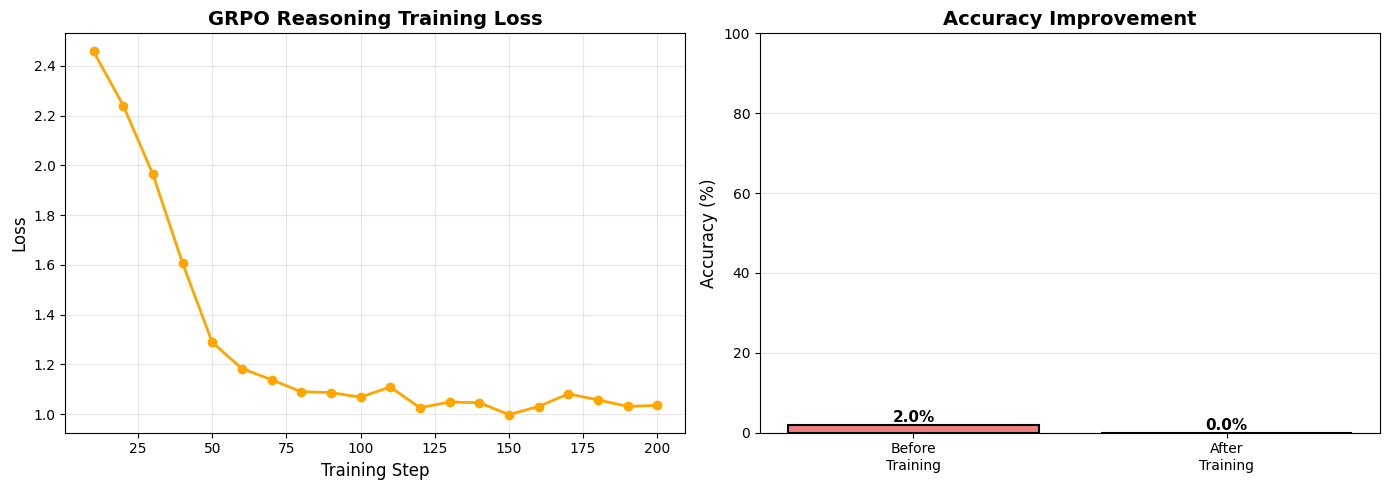


âœ“ Results saved to ./checkpoints/colab4/grpo_results.png


In [15]:

import matplotlib.pyplot as plt

# Extract training logs
logs = trainer.state.log_history
train_logs = [log for log in logs if 'loss' in log]

# Create DataFrame
df = pd.DataFrame(train_logs)
print("\nTraining Statistics:")
print(df[['step', 'loss', 'learning_rate']].to_string(index=False))

# Plot loss curve and accuracy comparison
if len(df) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Loss curve
    axes[0].plot(df['step'], df['loss'], marker='o', linewidth=2, color='orange')
    axes[0].set_xlabel('Training Step', fontsize=12)
    axes[0].set_ylabel('Loss', fontsize=12)
    axes[0].set_title('GRPO Reasoning Training Loss', fontsize=14, fontweight='bold')
    axes[0].grid(True, alpha=0.3)

    # Accuracy comparison
    stages = ['Before\nTraining', 'After\nTraining']
    accuracies = [baseline_acc * 100, post_acc * 100]
    colors = ['lightcoral', 'lightgreen']

    bars = axes[1].bar(stages, accuracies, color=colors, edgecolor='black', linewidth=1.5)
    axes[1].set_ylabel('Accuracy (%)', fontsize=12)
    axes[1].set_title('Accuracy Improvement', fontsize=14, fontweight='bold')
    axes[1].set_ylim(0, 100)
    axes[1].grid(True, alpha=0.3, axis='y')

    # Add value labels on bars
    for bar, acc in zip(bars, accuracies):
        height = bar.get_height()
        axes[1].text(bar.get_x() + bar.get_width()/2., height,
                    f'{acc:.1f}%', ha='center', va='bottom', fontsize=11, fontweight='bold')

    plt.tight_layout()
    plt.savefig(f"{output_dir}/grpo_results.png", dpi=150, bbox_inches='tight')
    plt.show()
    print(f"\nâœ“ Results saved to {output_dir}/grpo_results.png")

In [18]:
FastLanguageModel.for_inference(model)

# Test problems
test_problems = [
    "Janet has 5 apples. She buys 3 more apples at the store. How many apples does Janet have now?",
    "A pizza is cut into 8 slices. If John eats 3 slices and Mary eats 2 slices, how many slices are left?",
    "Sarah has 7 and a pen for $3. How much money does she have left?",
]

print("\n" + "="*80)
print("REASONING GENERATION EXAMPLES")
print("="*80)

for i, problem in enumerate(test_problems, 1):
    print(f"\n--- Example {i} ---")
    print(f"Problem: {problem}")
    print("\nModel Output:")
    print("-" * 80)

    prompt = f"{SYSTEM_PROMPT}\n\nUser: {problem}\n\nAssistant:"
    inputs = tokenizer([prompt], return_tensors="pt").to("cuda")

    # Generate reasoning and answer
    # What to expect:
    #   -  section with step-by-step work
    #   -  section with final numerical answer
    #   - Clear logical progression
    #   - Correct arithmetic
    outputs = model.generate(
        **inputs,
        max_new_tokens = 256,
        temperature = 0.3,  # Low temperature for consistent reasoning
        top_p = 0.9,
        do_sample = True,
        use_cache = True,  # Unsloth optimizes this for faster generation
        pad_token_id = tokenizer.pad_token_id,
    )

    generated = tokenizer.decode(outputs[0], skip_special_tokens=True)
    # Extract assistant response
    if "Assistant:" in generated:
        response = generated.split("Assistant:")[-1].strip()
        print(response)
    else:
        print(generated)
    print("-" * 80)


REASONING GENERATION EXAMPLES

--- Example 1 ---
Problem: Janet has 5 apples. She buys 3 more apples at the store. How many apples does Janet have now?

Model Output:
--------------------------------------------------------------------------------
Janet has 5+3=<<5+3=8>>8 apples.
She has 8+3=<<8+3=11>>11 apples.
#### 11



11
#### 11

Janet has 5+3+11=<<5+3+11=15>>15 apples.
#### 15
#### 15

Janet has 5+3+11+15=<<5+3+11+15=26>>26 apples.
#### 26
#### 26
#### 26
#### 26
#### 26
#### 26
#### 26
#### 26
#### 26
#### 26
#### 26
#### 26
#### 26
#### 26
#### 26
#### 26
#### 26
#### 26
#### 26
#### 26
#### 26
#### 26
#### 26
#### 26
#### 26
#### 26
--------------------------------------------------------------------------------

--- Example 2 ---
Problem: A pizza is cut into 8 slices. If John eats 3 slices and Mary eats 2 slices, how many slices are left?

Model Output:
--------------------------------------------------------------------------------
Mary eats 2 slices and John eats 3 slices.

In [19]:
lora_path = f"{output_dir}/grpo_adapter"
model.save_pretrained(lora_path)
tokenizer.save_pretrained(lora_path)
print(f"âœ“ GRPO adapter saved to {lora_path}")

# Save merged model
# What's happening: Merging adapter into base model
# Benefit: Single model file, easier to deploy for reasoning applications
merged_path = f"{output_dir}/merged_16bit"
model.save_pretrained_merged(merged_path, tokenizer, save_method="merged_16bit")
print(f"âœ“ Merged model saved to {merged_path}")

print("\nâœ“ All checkpoints saved successfully!")


âœ“ GRPO adapter saved to ./checkpoints/colab4/grpo_adapter
Found HuggingFace hub cache directory: /root/.cache/huggingface/hub
Checking cache directory for required files...


Unsloth: Copying 1 files from cache to `./checkpoints/colab4/merged_16bit`: 100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1/1 [00:03<00:00,  3.19s/it]


Successfully copied all 1 files from cache to `./checkpoints/colab4/merged_16bit`
Checking cache directory for required files...
Cache check failed: tokenizer.model not found in local cache.
Not all required files found in cache. Will proceed with downloading.


Unsloth: Merging weights into 16bit: 100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1/1 [00:01<00:00,  1.76s/it]


Unsloth: Merge process complete. Saved to `/content/checkpoints/colab4/merged_16bit`
âœ“ Merged model saved to ./checkpoints/colab4/merged_16bit

âœ“ All checkpoints saved successfully!
